In [289]:
import sys
sys.path.append('../../pyutils')

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

import metrics

# Lookup table Embedding

A lookup table embedding learns the embedding of a list of symbols. They usually perform better than using one-hot encoding.  
We have a dictionary of $K$ symbols, and assign to each one of them a unique vector.  
They can be trained with backpropagation.

Parameters:
- K: number of embeddings (size of the dictionary)
- p: dimension of the output vector for each symbol

Input:
$$x \in \mathbb{N}^{N}$$

The input is a vector of $N$ symbols, each represented by the symbol index (from $0$ to $K-1$).

Output:
$$y \in \mathbb{R}^{N*p}$$

The output is a matrix, each row $y_i$ contains the embedding of symbol $x_i$.

In [12]:
K = 26
p = 3
N = 107

x = np.random.randint(0, K, size=(N,))
x = torch.from_numpy(x)

embed = nn.Embedding(K, p)

y = embed(x)
print(y.shape)

torch.Size([107, 3])


# Elman RNN Cell

Input:
- input: $x \in \mathbb{R}^{N*p}$
- hidden state: $h \in \mathbb{R}^{N*k}$

Output:
- next hidden state: $h' \in \mathbb{R}^{N*k}$

with $N$ batch size, $p$ input dimmension, and $k$ hidden dimension

Learnable parameters:
- $w_{ih} \in \mathbb{R}^{k*p}$
- $b_{ih} \in \mathbb{R}^k$
- $w_{hh} \in \mathbb{R}^{k*k}$
- $b_{hh} \in \mathbb{R}^k$

$$h' = \tanh (w_{ih}^T x + b_{ih} + w_{hh}^T g + b_{hh})$$

In [45]:
N = 17
XDIM = 8
HDIM = 5

cell = torch.nn.RNNCell(XDIM, HDIM)
wi, wh, bi, bh = (x.data.numpy() for x in cell.parameters())
print(wi.shape, bi.shape)
print(wh.shape, bh.shape)

x = np.random.randn(N, XDIM).astype(np.float32)
h = np.random.randn(N, HDIM).astype(np.float32)
h = np.tanh(x @ wi.T + bi + h @ wh.T + bh)
print(h.shape)

tx = torch.from_numpy(x)
th = torch.from_numpy(h)
th = cell(tx, th)

print(metrics.tdist(h, th.data.numpy()))

(5, 8) (5,)
(5, 5) (5,)
(17, 5)
4.8643146


With the previous RNNCell, we had to pass a whole sequence through the network by passing every element one by one.  
This can be done directly.

This technique is also possible with every other RNN Cells

In [89]:
XDIM = 8
HDIM = 5
BATCH_SIZE = 32
SEQ_LEN = 17

class MyRNN:
    
    def __init__(self, wi, wh, bi, bh):
        self.wi = wi
        self.wh = wh
        self.bi = bi
        self.bh = bh
        
    def forward_one(self, x, h):
        if h is None:
            h = np.zeros((len(x), len(self.bh)))
            
        return np.tanh(x @ self.wi.T + self.bi 
                       + h @ self.wh.T + self.bh)
    
    def forward(self, x):
        h = None
        n = len(x)
        out = np.empty((n, x.shape[1], len(self.bh)))
        
        for i in range(n):
            h = self.forward_one(x[i], h)
            out[i] = h
    
        h_n = np.expand_dims(out[-1], 0)
        return out, h_n
        

rnn = torch.nn.RNN(XDIM, HDIM)
wi, wh, bi, bh = (x.data.numpy() for x in cell.parameters())
my_rnn = MyRNN(wi, wh, bi, bh)

x = np.random.randn(SEQ_LEN, BATCH_SIZE, XDIM).astype(np.float32)
out, h = my_rnn.forward(x)
print(out.shape, h.shape)

tx = torch.from_numpy(x)
tout, th = rnn(tx)
print(tout.shape, th.shape)

print(metrics.tdist(out, tout.data.numpy()))

(17, 32, 5) (1, 32, 5)
torch.Size([17, 32, 5]) torch.Size([1, 32, 5])
43.79904659633917


# Long-Short Term Memory (LSTM) Cell 

## Input
- input: $x \in \mathbb{R}^{N*p}$
- hidden state: $h \in \mathbb{R}^{N*k}$
- cell state: $c \in \mathbb{R}^{N*k}$

## Output
- next hidden state: $h' \in \mathbb{R}^{N*k}$
- next cell state: $c' \in \mathbb{R}^{N*k}$

with $N$ batch size, $p$ input dimmension, and $k$ hidden dimension

## Learnable parameters
- $w_{ii} \in \mathbb{R}^{k*p}$
- $b_{ii} \in \mathbb{R}^k$
- $w_{if} \in \mathbb{R}^{k*p}$
- $b_{if} \in \mathbb{R}^k$
- $w_{ig} \in \mathbb{R}^{k*p}$
- $b_{ig} \in \mathbb{R}^k$
- $w_{ih} \in \mathbb{R}^{k*p}$
- $b_{ih} \in \mathbb{R}^k$


- $w_{hi} \in \mathbb{R}^{k*k}$
- $b_{hi} \in \mathbb{R}^k$
- $w_{hf} \in \mathbb{R}^{k*k}$
- $b_{hf} \in \mathbb{R}^k$
- $w_{hg} \in \mathbb{R}^{k*k}$
- $b_{hg} \in \mathbb{R}^k$
- $w_{ho} \in \mathbb{R}^{k*k}$
- $b_{ho} \in \mathbb{R}^k$


## Forward pass

$$i = \sigma (w_{ii}^T x + b_{ii} + w_{hi}^T g + b_{hi})$$
$$f = \sigma (w_{if}^T x + b_{if} + w_{hf}^T g + b_{hf})$$
$$g = \tanh (w_{ig}^T x + b_{ig} + w_{hg}^T g + b_{hg})$$
$$o = \sigma (w_{io}^T x + b_{io} + w_{ho}^T g + b_{ho})$$
$$c' = f \odot c + i \odot g$$
$$h' = o \odot \tanh(c')$$

## Optimization

We can concatenate weights matrices and vectors to have less parameters:
- $w_i = (w_{ii}, w_{if}, w_{ig}, w_{io})$
- $b_i = (b_{ii}, b_{if}, b_{ig}, b_{io})$
- $w_h = (w_{hi}, w_{hf}, w_{hg}, w_{ho})$
- $b_h = (b_{hi}, b_{hf}, b_{hg}, b_{ho})$

In [128]:
N = 17
XDIM = 8
HDIM = 5

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class MyLSTMCell:
    
    def __init__(self, wi, wh, bi, bh):
        self.wi = wi #(wii, wif, wig, wio)
        self.wh = wh
        self.bi = bi
        self.bh = bh
        
        self.idim = self.wi.shape[1]
        self.hdim = self.wh.shape[1]
        
    def forward(self, x, h0 = None, c0 = None):
        n = len(x)
        if h0 is None:
            h0 = np.zeros((n, self.hdim))
        if c0 is None:
            c0 = np.zeros((n, self.hdim))
    
        z = x @ self.wi.T + self.bi + h0 @ self.wh.T + self.bh
        
        i = sigmoid(z[:, :self.hdim])
        f = sigmoid(z[:, self.hdim:2*self.hdim])
        g = np.tanh(z[:, 2*self.hdim:3*self.hdim])
        o = sigmoid(z[:, 3*self.hdim:])
        
        c1 = f * c0 + i * g
        h1 = o * np.tanh(c1)
        return h1, c1



lstm = torch.nn.LSTMCell(XDIM, HDIM)
wi, wh, bi, bh = (x.data.numpy() for x in lstm.parameters())
print(wi.shape, wh.shape, bi.shape, bh.shape)

my_lstm = MyLSTMCell(wi, wh, bi, bh)
x = np.random.randn(N, XDIM).astype(np.float32)
h0 = np.random.randn(N, HDIM).astype(np.float32)
c0 = np.random.randn(N, HDIM).astype(np.float32)
h1, c1 = my_lstm.forward(x, h0, c0)
print(h1.shape, c1.shape)

tx = torch.from_numpy(x)
th0 = torch.from_numpy(h0)
tc0 = torch.from_numpy(c0)
th1, tc1 = lstm(tx, (th0, tc0))

print(metrics.tdist(c1, tc1.data.numpy()))

(20, 8) (20, 5) (20,) (20,)
(17, 5) (17, 5)
2.6645594e-07


## Sequence data

With the previous LSTMCell, we had to pass a whole sequence through the network by passing every element one by one.  
This can be done directly.

This technique is also possible with every other RNN Cells.

In [222]:
XDIM = 8
HDIM = 5
BATCH_SIZE = 32
SEQ_LEN = 17


class MyLSTM:
    
    def __init__(self, wi, wh, bi, bh):
        self.cell = MyLSTMCell(wi, wh, bi, bh)
        self.idim = self.cell.idim
        self.hdim = self.cell.hdim
        
    def forward(self, x, h0 = None, c0 = None):
        n = len(x)
        if h0 is None:
            h0 = np.zeros((1, x.shape[1], self.hdim))
        if c0 is None:
            c0 = np.zeros((1, x.shape[1], self.hdim))
        h, c = h0[0], c0[0]
        
        out = np.empty((n, x.shape[1], self.hdim))
        
        for i in range(n):
            h, c = self.cell.forward(x[i], h, c)
            out[i] = h
            
        
        return out, np.expand_dims(h, 0), np.expand_dims(c, 0)

lstm = torch.nn.LSTM(XDIM, HDIM)
wi, wh, bi, bh = (x.data.numpy() for x in lstm.parameters())

my_lstm = MyLSTM(wi, wh, bi, bh)
x = np.random.randn(SEQ_LEN, BATCH_SIZE, XDIM).astype(np.float32)
out, h_n, c_n = my_lstm.forward(x)
print(out.shape, h_n.shape, c_n.shape)

tx = torch.from_numpy(x)
tout, (th_n, tc_n) = lstm(tx)

print(metrics.tdist(out, tout.data.numpy()))
print(metrics.tdist(h_n, th_n.data.numpy()))
print(metrics.tdist(c_n, tc_n.data.numpy()))

(17, 32, 5) (1, 32, 5) (1, 32, 5)
8.097244570674472e-07
1.8593573488227028e-07
3.0447839357184706e-07


## Variable length Sequence data

It's also possible to pass sequences of different sizes

In [227]:
XDIM = 8
HDIM = 5
BATCH_SIZE = 32

class MyLSTM:
    
    def __init__(self, wi, wh, bi, bh):
        self.cell = MyLSTMCell(wi, wh, bi, bh)
        self.idim = self.cell.idim
        self.hdim = self.cell.hdim
        
    def forward(self, x, lengths, h0 = None, c0 = None):
        
        n = len(x)
        if h0 is None:
            h0 = np.zeros((1, x.shape[1], self.hdim))
        if c0 is None:
            c0 = np.zeros((1, x.shape[1], self.hdim))
        h, c = h0[0], c0[0]
        
        batch_sizes = [np.sum(lengths > i) for i in range(n)]
        
        out = np.empty((np.sum(batch_sizes), self.hdim))
        outi = 0
        
        for i in range(n):
            cur_size = batch_sizes[i]
            h1, c1 = self.cell.forward(x[i, :cur_size], 
                                     h[:cur_size], c[:cur_size])
            h[:cur_size], c[:cur_size] = h1, c1
            out[outi:outi + cur_size] = h1
            outi += cur_size
        
        return out, np.expand_dims(h, 0), np.expand_dims(c, 0)

lengths = np.random.randint(1, 18, size=(BATCH_SIZE,))
lengths = np.sort(lengths)[::-1].copy()
max_len = lengths[0]

x = np.zeros((max_len, BATCH_SIZE, XDIM)).astype(np.float32)
for i in range(BATCH_SIZE):
    x[:lengths[i], i, :] = np.random.randn(lengths[i], XDIM)

lstm = torch.nn.LSTM(XDIM, HDIM)
wi, wh, bi, bh = (x.data.numpy() for x in lstm.parameters())

my_lstm = MyLSTM(wi, wh, bi, bh)
out, h_n, c_n = my_lstm.forward(x, lengths)
print(out.shape, h_n.shape, c_n.shape)

tx = torch.from_numpy(x)
tlengths = torch.from_numpy(lengths)
tx = nn.utils.rnn.pack_padded_sequence(tx, tlengths)
tout, (th_n, tc_n) = lstm(tx)

print(metrics.tdist(out, tout.data.data.numpy()))
print(metrics.tdist(h_n, th_n.data.numpy()))
print(metrics.tdist(c_n, tc_n.data.numpy()))

(307, 5) (1, 32, 5) (1, 32, 5)
6.44437620786007e-07
2.1618503313251112e-07
4.206786564922322e-07


## Bidirectional

We can combine 2 LSTM, one reading the sequence from left to right, the other from right to left

In [266]:
XDIM = 8
HDIM = 5
BATCH_SIZE = 32
SEQ_LEN = 17


class MyBiLSTM:
    
    def __init__(self, wil, whl, bil, bhl, wir, whr, bir, bhr):
        self.cell_l = MyLSTMCell(wil, whl, bil, bhl)
        self.cell_r = MyLSTMCell(wir, whr, bir, bhr)
        self.idim = self.cell_l.idim
        self.hdim = self.cell_l.hdim
        
    def forward(self, x, h0 = None, c0 = None):
        n = len(x)
        if h0 is None:
            h0 = np.zeros((2, x.shape[1], self.hdim))
        if c0 is None:
            c0 = np.zeros((2, x.shape[1], self.hdim))
        h, c = h0, c0
        
        out = np.empty((n, x.shape[1], 2*self.hdim))
        
        for i in range(n):
            h[0], c[0] = self.cell_l.forward(x[i], h[0], c[0])
            h[1], c[1] = self.cell_r.forward(x[n-1-i], h[1], c[1])
            out[i,:,:self.hdim] = h[0]
            out[n-1-i,:,self.hdim:] = h[1]
            
        
        return out, h, c

lstm = torch.nn.LSTM(XDIM, HDIM, bidirectional=True)
wil, whl, bil, bhl, wir, whr, bir, bhr = (
    x.data.numpy() for x in lstm.parameters())


my_lstm = MyBiLSTM(wil, whl, bil, bhl, wir, whr, bir, bhr)
x = np.random.randn(SEQ_LEN, BATCH_SIZE, XDIM).astype(np.float32)
out, h_n, c_n = my_lstm.forward(x)
print(out.shape, h_n.shape, c_n.shape)

tx = torch.from_numpy(x)
tout, (th_n, tc_n) = lstm(tx)

print(metrics.tdist(out, tout.data.numpy()))
print(metrics.tdist(h_n, th_n.data.numpy()))
print(metrics.tdist(c_n, tc_n.data.numpy()))

(17, 32, 10) (2, 32, 5) (2, 32, 5)
1.2332841259080759e-06
3.194179280086925e-07
5.742208545957593e-07


# Gated Recurrent Unit (GRU) Cell 

## Input
- input: $x \in \mathbb{R}^{N*p}$
- hidden state: $h \in \mathbb{R}^{N*k}$

## Output
- next hidden state: $h' \in \mathbb{R}^{N*k}$

with $N$ batch size, $p$ input dimmension, and $k$ hidden dimension

## Learnable parameters
- $w_{ir} \in \mathbb{R}^{k*p}$
- $b_{ir} \in \mathbb{R}^k$
- $w_{iz} \in \mathbb{R}^{k*p}$
- $b_{iz} \in \mathbb{R}^k$
- $w_{in} \in \mathbb{R}^{k*p}$
- $b_{in} \in \mathbb{R}^k$


- $w_{hr} \in \mathbb{R}^{k*k}$
- $b_{hr} \in \mathbb{R}^k$
- $w_{hz} \in \mathbb{R}^{k*k}$
- $b_{hz} \in \mathbb{R}^k$
- $w_{hn} \in \mathbb{R}^{k*k}$
- $b_{hn} \in \mathbb{R}^k$


## Forward pass

$$i = \sigma (w_{ii}^T x + b_{ii} + w_{hi}^T g + b_{hi})$$
$$f = \sigma (w_{if}^T x + b_{if} + w_{hf}^T g + b_{hf})$$
$$g = \tanh (w_{ig}^T x + b_{ig} + w_{hg}^T g + b_{hg})$$
$$o = \sigma (w_{io}^T x + b_{io} + w_{ho}^T g + b_{ho})$$
$$c' = f \odot c + i \odot g$$
$$h' = o \odot \tanh(c')$$

## Optimization

We can concatenate weights matrices and vectors to have less parameters:
- $w_i = (w_{ir}, w_{iz}, w_{in})$
- $b_i = (b_{ir}, b_{iz}, b_{in})$
- $w_h = (w_{hr}, w_{hz}, w_{hn})$
- $b_h = (b_{hr}, b_{hz}, b_{hn})$

In [286]:
N = 17
XDIM = 8
HDIM = 5

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class MyGRUCell:
    
    def __init__(self, wi, wh, bi, bh):
        self.wi = wi #(wir, wiz, win)
        self.wh = wh
        self.bi = bi
        self.bh = bh
        
        self.idim = self.wi.shape[1]
        self.hdim = self.wh.shape[1]
        
    def forward(self, x, h0 = None):
        n = len(x)
        if h0 is None:
            h0 = np.zeros((n, self.hdim))
    
        z1 = (x @ self.wi[:2*self.hdim].T + self.bi[:2*self.hdim]
            + h0 @ self.wh[:2*self.hdim].T + self.bh[:2*self.hdim])
        r = sigmoid(z1[:, :self.hdim])
        z = sigmoid(z1[:, self.hdim:])
        
        z2 = (x @ self.wi[2*self.hdim:].T + self.bi[2*self.hdim:]
            + r*(h0 @ self.wh[2*self.hdim:].T + self.bh[2*self.hdim:]))
        
        
        n = np.tanh(z2)
        
        h1 = (1 - z) * n + z * h0
        return h1



gru = torch.nn.GRUCell(XDIM, HDIM)
wi, wh, bi, bh = (x.data.numpy() for x in gru.parameters())
print(wi.shape, wh.shape, bi.shape, bh.shape)

my_gru = MyGRUCell(wi, wh, bi, bh)
x = np.random.randn(N, XDIM).astype(np.float32)
h0 = np.random.randn(N, HDIM).astype(np.float32)
h1 = my_gru.forward(x, h0)
print(h1.shape)

tx = torch.from_numpy(x)
th0 = torch.from_numpy(h0)
th1 = gru(tx, th0)

print(metrics.tdist(h1, th1.data.numpy()))

(15, 8) (15, 5) (15,) (15,)
(17, 5)
3.5207444e-07


# RNN: Classification example

For classification tasks, the network takes as input a sequence, element by element, and use the last hidden vector to make the prediction.  

In this example, we classify 8x8 digit images. Each row of the image is considered as a different of sequence of size 8.

(1797, 64) (1797,)


/home/aiw/anaconda3/envs/torch/lib/python3.7/site-packages/torch/backends/cudnn/__init__.py:102: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "


Epoch 1: train_loss = 2.305, train_acc = 0.116 test_loss = 2.316, test_acc = 0.086
Epoch 11: train_loss = 1.135, train_acc = 0.653 test_loss = 0.987, test_acc = 0.769
Epoch 21: train_loss = 0.681, train_acc = 0.810 test_loss = 0.610, test_acc = 0.839
Epoch 31: train_loss = 0.508, train_acc = 0.866 test_loss = 0.424, test_acc = 0.856
Epoch 41: train_loss = 0.408, train_acc = 0.889 test_loss = 0.317, test_acc = 0.894
Epoch 51: train_loss = 0.326, train_acc = 0.902 test_loss = 0.268, test_acc = 0.903
Epoch 61: train_loss = 0.272, train_acc = 0.928 test_loss = 0.231, test_acc = 0.928
Epoch 71: train_loss = 0.245, train_acc = 0.930 test_loss = 0.191, test_acc = 0.925
Epoch 81: train_loss = 0.213, train_acc = 0.943 test_loss = 0.207, test_acc = 0.931
Epoch 91: train_loss = 0.192, train_acc = 0.945 test_loss = 0.153, test_acc = 0.944
Epoch 101: train_loss = 0.151, train_acc = 0.958 test_loss = 0.128, test_acc = 0.953
Epoch 111: train_loss = 0.162, train_acc = 0.955 test_loss = 0.130, test_acc

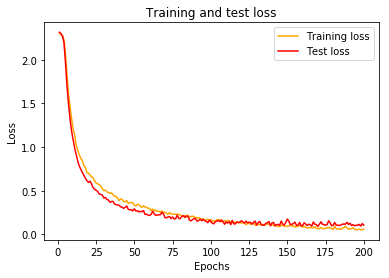

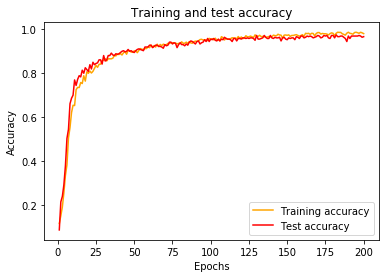

In [290]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Hyperparameters

INPUT_DIM = 8
NHIDDEN = 30
NCLASSES = 10
BATCH_SIZE = 64
NEPOCHS = 200
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Prepare dataset

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx].reshape(8, 8)
        y = self.y[idx]
        return x, y
    
data = load_digits()
X, y = data.data.astype(np.float32), data.target.astype(np.int64)
X /= 16
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

train_ds = MyDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_ds = MyDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)



# Create model

class Model(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.drop = nn.Dropout(.5)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def forward(self, x):
        x = x.permute((1, 0, 2))
        out, (h_n, c_n) = self.lstm(x)
        h = h_n.squeeze()
        h = self.drop(h)
        return self.fc(h)
    
net = Model(INPUT_DIM, NHIDDEN, NCLASSES).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)



# Train model

def run_epoch(model, data, criterion, optimizer=None):
    corr = 0
    run_loss = 0.
    
    model.train(bool(optimizer))
    
    for Xb, yb in data:
        Xb, yb = Xb.to(device), yb.to(device)
        if optimizer:
            optimizer.zero_grad()
        
        with torch.set_grad_enabled(bool(optimizer)):
        
            logits = model(Xb)
            loss = criterion(logits, yb)
            preds = torch.argmax(logits, 1)
            corr += (preds == yb).sum().item()
            run_loss += loss.item() * len(Xb)
        
            if optimizer:
                loss.backward()
                optimizer.step()
            
        
    return run_loss / len(data.dataset), corr / len(data.dataset)

def train(model, train_dl, criterion, optimizer):

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(NEPOCHS):

        train_loss, train_acc = run_epoch(model, train_dl, criterion, 
                                          optimizer)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        test_loss, test_acc = run_epoch(model, test_dl, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if epoch % 10 == 0:
            print(('Epoch {}: train_loss = {:.3f}, '
                   + 'train_acc = {:.3f} '
                  + 'test_loss = {:.3f}, '
                   + 'test_acc = {:.3f}').format(
                epoch+1, train_loss, train_acc, test_loss, test_acc))
            
    return train_losses, train_accs, test_losses, test_accs

train_losses, train_accs, test_losses, test_accs = train(
    net, train_dl, criterion, optimizer)



# Display results

epochs = range(1, NEPOCHS + 1)

plt.plot(epochs, train_losses, c='orange', label='Training loss')
plt.plot(epochs, test_losses, c='red', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(epochs, train_accs, c='orange', label='Training accuracy')
plt.plot(epochs, test_accs, c='red', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()